In [1]:
'''
(C) Copyright Renata Wong 2023.

This code is licensed under the Apache License, Version 2.0. You may obtain a copy of this license 
at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this copyright notice, and modified files 
need to carry a notice indicating that they have been altered from the originals.

For details see 
Piotr Czarnik, Andrew Arrasmith, Patrick J. Coles, and Lukasz Cincio. 
"Error mitigation with Clifford quantum-circuit data". Quantum 5, 592 (2021).
'''

from qiskit import QuantumCircuit, QuantumRegister
import numpy as np

# imports for generating training circuits
from qiskit.circuit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass
import numpy as np
import random
from random import choices


nqubits = 2
nshots = 20000

def getParity(n):
    parity = 0
    while n:
        parity = ~parity
        n = n & (n - 1)
    return parity

import itertools
def expectation_value_from_counts(counts):
    exp_val = 0
    for x in map(''.join, itertools.product('01', repeat=nqubits)):
        if x in counts:   # making sure that x is in the output as the counts dictionary contains no values with 0 occurrence
            if getParity(int(x,2)) == -1:
                exp_val = exp_val - counts[x]
            if getParity(int(x,2)) == 0:
                exp_val = exp_val + counts[x]
    return exp_val/nshots

# mapping circuit to near Clifford circuits with N = number of non-Clifford gates
# Z gates with these angles/exponents are Clifford gates.
clifford_exponents = np.array([0.0, 0.5, 1.0, 1.5])
clifford_angles = [exponent * np.pi for exponent in clifford_exponents]


# replacing some non-Clifford gates with Clifford gates in the input circuit

class RZTranslator(TransformationPass):
    """A transpiler pass to replace RZ(a) gates with RZ(pi/2)^n gates, for n = 0, 1, 2, 3 at random."""

    def run(self, dag):
        N = 0.3                                   # TUNABLE: here, replace 30% of the non-Clifford gates
        # iterate over all operations
        for node in dag.op_nodes():

            # if we hit a RZ gate replace it by RZ(pi/2)^n at random
            if node.op.name in ["rz"]:
                # get the rotation angle
                angle = node.op.params[0]

                # calculate the replacement
                replacement = QuantumCircuit(1)
                if node.op.name == "rz":
                    if angle not in clifford_angles:
                        if choices([0,1], [N, 1-N])[0] == 0:
                            replacement.rz(random.choice(clifford_angles),0)
                        else:
                            replacement.rz(angle,0)

                # replace the node with our new decomposition
                dag.substitute_node_with_dag(node, circuit_to_dag(replacement))
        
        return dag
   
    
# Least-squares regression from scipy
#from scipy.stats import linregress
def least_squares_regression(noiseless_exp_vals, noisy_exp_vals):
    result = scipy.stats.linregress(noisy_exp_vals, noiseless_exp_vals)
    return (result.slope, result.intercept)




'''
EXAMPLE CIRCUIT. ADJUSTABLE. 
'''
def append_gates(qc):
    for rep in range(5):
        for qubit in range(nqubits):
            qc.h(qubit)  
        for qubit in range(nqubits)[::2]:
            qc.rz(1.75, qubit)
        for qubit in range(nqubits)[1::2]:
            qc.rz(2.31, qubit)
        for qubit in range(nqubits)[::2]:
            qc.cx(qubit, qubit+1)     
        for qubit in range(nqubits)[::2]:
            qc.rz(-1.17, qubit)
        for qubit in range(nqubits)[1::2]:
            qc.rz(3.23, qubit)
        for qubit in range(nqubits):
            qc.rx(np.pi/2, qubit)    
    return qc

# The original vcircuit
qc = QuantumCircuit(nqubits)
append_gates(qc)

training_circuits_no_measurement_all = []  
for _ in range(500):
    training_circuits_no_measurement_all.append(RZTranslator()(qc))

print(*training_circuits_no_measurement_all)

     ┌───┐┌──────────┐      ┌───────┐  ┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(1.75) ├──■───┤ Rz(π) ├──┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
     ├───┤├─────────┬┘┌─┴─┐┌┴───────┴─┐├─────────┤├───┤└┬───────┬─┘┌─┴─┐»
q_1: ┤ H ├┤ Rz(π/2) ├─┤ X ├┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(0) ├──┤ X ├»
     └───┘└─────────┘ └───┘└──────────┘└─────────┘└───┘ └───────┘  └───┘»
«     ┌───────────┐┌─────────┐┌───┐┌──────────┐     ┌─────────┐ ┌─────────┐»
«q_0: ┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──┤ Rz(π/2) ├─┤ Rx(π/2) ├»
«     └┬──────────┤├─────────┤├───┤├──────────┤┌─┴─┐├─────────┴┐├─────────┤»
«q_1: ─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├┤ Rz(3π/2) ├┤ Rx(π/2) ├»
«      └──────────┘└─────────┘└───┘└──────────┘└───┘└──────────┘└─────────┘»
«     ┌───┐┌──────────┐      ┌───────┐  ┌─────────┐┌───┐┌──────────┐     »
«q_0: ┤ H ├┤ Rz(1.75) ├──■───┤ Rz(π) ├──┤ Rx(π/2) ├┤ H ├┤ Rz(3π/2) ├──■──»
«     ├───┤└┬───────┬─┘┌─┴─┐┌┴───────┴─┐├─────────┤├───┤├──────────┤┌─┴─┐»
«q_1: ┤ H ├─┤ Rz(0) 

«      └──────────┘└─────────┘      ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(3π/2) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
     ├───┤└┬───────┬─┘┌─┴─┐└┬──────────┤├─────────┤├───┤├──────────┤┌─┴─┐»
q_1: ┤ H ├─┤ Rz(π) ├──┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├»
     └───┘ └───────┘  └───┘ └──────────┘└─────────┘└───┘└──────────┘└───┘»
«      ┌───────┐  ┌─────────┐┌───┐┌──────────┐     ┌───────────┐┌─────────┐»
«q_0: ─┤ Rz(0) ├──┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├»
«     ┌┴───────┴─┐├─────────┤├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤»
«q_1: ┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(3π/2) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├»
«     └──────────┘└─────────┘└───┘└──────────┘└───┘ └──────────┘└─────────┘»
«     ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
«q_0: ┤ H ├┤ Rz(3π/2) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
«     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤├───┤

«       └───────┘  └─────────┘      ┌───┐┌──────────┐      ┌───────┐  ┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(1.75) ├──■───┤ Rz(π) ├──┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
     ├───┤├──────────┤┌─┴─┐┌┴───────┴─┐├─────────┤├───┤└┬───────┬─┘┌─┴─┐»
q_1: ┤ H ├┤ Rz(2.31) ├┤ X ├┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(0) ├──┤ X ├»
     └───┘└──────────┘└───┘└──────────┘└─────────┘└───┘ └───────┘  └───┘»
«     ┌───────────┐┌─────────┐┌───┐ ┌───────┐       ┌───────────┐┌─────────┐»
«q_0: ┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(π) ├────■──┤ Rz(-1.17) ├┤ Rx(π/2) ├»
«     └┬──────────┤├─────────┤├───┤┌┴───────┴─┐┌─┴─┐└─┬───────┬─┘├─────────┤»
«q_1: ─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├──┤ Rz(0) ├──┤ Rx(π/2) ├»
«      └──────────┘└─────────┘└───┘└──────────┘└───┘  └───────┘  └─────────┘»
«     ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐ ┌───────┐       »
«q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(π) ├────■──»
«     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤├───┤

«      └──────────┘└─────────┘      ┌───┐┌──────────┐     ┌──────────┐┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(3π/2) ├──■──┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├┤ Rz(3π/2) ├──■──»
     ├───┤└┬───────┬─┘┌─┴─┐├──────────┤├─────────┤├───┤└┬───────┬─┘┌─┴─┐»
q_1: ┤ H ├─┤ Rz(0) ├──┤ X ├┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(π) ├──┤ X ├»
     └───┘ └───────┘  └───┘└──────────┘└─────────┘└───┘ └───────┘  └───┘»
«     ┌──────────┐┌─────────┐┌───┐┌──────────┐     ┌───────────┐┌─────────┐»
«q_0: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├»
«     ├──────────┤├─────────┤├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤»
«q_1: ┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├»
«     └──────────┘└─────────┘└───┘└──────────┘└───┘ └──────────┘└─────────┘»
«     ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
«q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
«     ├───┤├──────────┤┌─┴─┐└─┬───────┬─┘├─────────┤├───┤├────

«      └───────┘  └─────────┘      ┌───┐┌──────────┐     ┌───────┐┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(0) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
     ├───┤├──────────┤┌─┴─┐├───────┤├─────────┤├───┤└┬───────┬─┘┌─┴─┐»
q_1: ┤ H ├┤ Rz(2.31) ├┤ X ├┤ Rz(0) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(0) ├──┤ X ├»
     └───┘└──────────┘└───┘└───────┘└─────────┘└───┘ └───────┘  └───┘»
«     ┌─────────┐ ┌─────────┐┌───┐┌─────────┐      ┌───────────┐┌─────────┐»
«q_0: ┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ H ├┤ Rz(π/2) ├───■──┤ Rz(-1.17) ├┤ Rx(π/2) ├»
«     ├─────────┴┐├─────────┤├───┤├─────────┴┐┌─┴─┐└┬──────────┤├─────────┤»
«q_1: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├┤ Rz(3π/2) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├»
«     └──────────┘└─────────┘└───┘└──────────┘└───┘ └──────────┘└─────────┘»
«     ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
«q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
«     ├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤├───┤├──────────┤┌─┴─┐»
«q

«      └──────────┘└─────────┘      ┌───┐ ┌───────┐       ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├─┤ Rz(π) ├────■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(3π/2) ├──■──»
     ├───┤┌┴───────┴─┐┌─┴─┐└┬──────────┤├─────────┤├───┤├─────────┬┘┌─┴─┐»
q_1: ┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(π/2) ├─┤ X ├»
     └───┘└──────────┘└───┘ └──────────┘└─────────┘└───┘└─────────┘ └───┘»
«     ┌───────────┐┌─────────┐┌───┐┌──────────┐     ┌───────────┐┌─────────┐»
«q_0: ┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├»
«     └┬──────────┤├─────────┤├───┤├──────────┤┌─┴─┐└┬──────────┤├─────────┤»
«q_1: ─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├─┤ Rz(3π/2) ├┤ Rx(π/2) ├»
«      └──────────┘└─────────┘└───┘└──────────┘└───┘ └──────────┘└─────────┘»
«     ┌───┐┌──────────┐     ┌─────────┐ ┌─────────┐┌───┐┌──────────┐     »
«q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
«     ├───┤├──────────┤┌─┴─┐├─────────┴┐├─────────┤├──

«     └───────┘└─────────┘      ┌───┐ ┌───────┐       ┌─────────┐ ┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├─┤ Rz(π) ├────■──┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
     ├───┤┌┴───────┴─┐┌─┴─┐├─────────┴┐├─────────┤├───┤├──────────┤┌─┴─┐»
q_1: ┤ H ├┤ Rz(2.31) ├┤ X ├┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(3π/2) ├┤ X ├»
     └───┘└──────────┘└───┘└──────────┘└─────────┘└───┘└──────────┘└───┘»
«     ┌───────────┐┌─────────┐┌───┐┌───────┐     ┌───────────┐┌─────────┐┌───┐»
«q_0: ┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(0) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├»
«     └┬──────────┤├─────────┤├───┤├───────┤┌─┴─┐└─┬───────┬─┘├─────────┤├───┤»
«q_1: ─┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(0) ├┤ X ├──┤ Rz(0) ├──┤ Rx(π/2) ├┤ H ├»
«      └──────────┘└─────────┘└───┘└───────┘└───┘  └───────┘  └─────────┘└───┘»
«     ┌───────┐     ┌───────┐┌─────────┐┌───┐┌───────┐     ┌─────────┐ »
«q_0: ┤ Rz(π) ├──■──┤ Rz(π) ├┤ Rx(π/2) ├┤ H ├┤ Rz(0) ├──■──┤ Rz(π/2) ├─»
«     ├───────┤┌─┴─┐├───────┤├─────────┤├───┤├───────┤┌─┴

In [2]:
# wrapping the circuit into a statefunction
# This does not take simulation output into account, hence is always the same, while simulation with measurement varies.
from qiskit.opflow import Z, StateFn, CircuitStateFn

observable = Z ^ 2

# expectation value of the original circuit
psi_qc = CircuitStateFn(qc)
exp_val_qc = (~psi_qc @ observable @ psi_qc).eval()
print('Exact expectation value of circuit of interest:', exp_val_qc.real)

noiseless_exp_vals = []   
training_circuits_no_measurement = []
for circuit in training_circuits_no_measurement_all: 
    psi = CircuitStateFn(circuit)
    expectation_value = (~psi @ observable @ psi).eval()
    if expectation_value >= exp_val_qc.real-0.05 and expectation_value <= exp_val_qc.real+0.05:
        noiseless_exp_vals.append(expectation_value.real)
        training_circuits_no_measurement.append(circuit)


for exp_val in noiseless_exp_vals:
    print('Exact expectation value:', exp_val)


Exact expectation value of circuit of interest: 0.20422260124463615
Exact expectation value: 0.20564451180991078
Exact expectation value: 0.1667968149172127
Exact expectation value: 0.17616177007471523
Exact expectation value: 0.22932935026258758
Exact expectation value: 0.19614438221762073
Exact expectation value: 0.24689142191617075
Exact expectation value: 0.2129656636843232
Exact expectation value: 0.2515852081652754
Exact expectation value: 0.22860131056402297
Exact expectation value: 0.1615004884971232
Exact expectation value: 0.23036445569399214
Exact expectation value: 0.17615936067170188
Exact expectation value: 0.2138452832177765
Exact expectation value: 0.15561871895786364
Exact expectation value: 0.2346368409693782
Exact expectation value: 0.24387233618442977
Exact expectation value: 0.1755683062670109
Exact expectation value: 0.22936228159925087
Exact expectation value: 0.24255938025019685
Exact expectation value: 0.2372251798833191
Exact expectation value: 0.2210329473014

In [3]:
'''
Generate training circuits with measurement for noisy simulation on quantum devices
'''


from qiskit import ClassicalRegister

# original circuit with measurement
qr_qc = QuantumRegister(nqubits)
cr_qc = ClassicalRegister(nqubits)
circ_qc = QuantumCircuit(qr_qc, cr_qc)
circ_qc.append(qc.to_instruction(), [qubit for qubit in range(nqubits)])
circ_qc.measure(qr_qc, cr_qc)

training_circuits_with_measurement = []
for circuit in training_circuits_no_measurement:
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)
    circ = QuantumCircuit(qr, cr)
    circ.append(circuit.to_instruction(), [qubit for qubit in range(nqubits)])
    circ.measure(qr, cr) 
    training_circuits_with_measurement.append(circ)
    
print(*training_circuits_with_measurement)

         ┌────────────┐┌─┐   
q3508_0: ┤0           ├┤M├───
         │  circuit-0 │└╥┘┌─┐
q3508_1: ┤1           ├─╫─┤M├
         └────────────┘ ║ └╥┘
   c1: 2/═══════════════╩══╩═
                        0  1           ┌────────────┐┌─┐   
q3509_0: ┤0           ├┤M├───
         │  circuit-0 │└╥┘┌─┐
q3509_1: ┤1           ├─╫─┤M├
         └────────────┘ ║ └╥┘
   c2: 2/═══════════════╩══╩═
                        0  1           ┌────────────┐┌─┐   
q3510_0: ┤0           ├┤M├───
         │  circuit-0 │└╥┘┌─┐
q3510_1: ┤1           ├─╫─┤M├
         └────────────┘ ║ └╥┘
   c3: 2/═══════════════╩══╩═
                        0  1           ┌────────────┐┌─┐   
q3511_0: ┤0           ├┤M├───
         │  circuit-0 │└╥┘┌─┐
q3511_1: ┤1           ├─╫─┤M├
         └────────────┘ ║ └╥┘
   c4: 2/═══════════════╩══╩═
                        0  1           ┌────────────┐┌─┐   
q3512_0: ┤0           ├┤M├───
         │  circuit-0 │└╥┘┌─┐
q3512_1: ┤1           ├─╫─┤M├
         └────────────┘ ║ └╥┘
   c5: 2/═

In [4]:
'''
Adding a noise model to our simulation
'''

from qiskit import transpile

from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo

from qiskit.providers.aer import AerSimulator

device_backend = FakeVigo()
coupling_map = device_backend.configuration().coupling_map
sim_vigo = AerSimulator.from_backend(device_backend)

noisy_exp_vals = []   
for circuit in training_circuits_with_measurement: 
    tqc = transpile(circuit, sim_vigo) 
    result_noise = sim_vigo.run(tqc, shots=nshots).result() 
    counts_noise = result_noise.get_counts(0) 
    noisy_exp_val = expectation_value_from_counts(counts_noise) 
    print('Noisy expectation value from counts: ', noisy_exp_val)
    noisy_exp_vals.append(noisy_exp_val)

Noisy expectation value from counts:  0.1406
Noisy expectation value from counts:  0.118
Noisy expectation value from counts:  0.1321
Noisy expectation value from counts:  0.1653
Noisy expectation value from counts:  0.1357
Noisy expectation value from counts:  0.1821
Noisy expectation value from counts:  0.167
Noisy expectation value from counts:  0.1736
Noisy expectation value from counts:  0.1521
Noisy expectation value from counts:  0.1233
Noisy expectation value from counts:  0.1491
Noisy expectation value from counts:  0.1195
Noisy expectation value from counts:  0.1608
Noisy expectation value from counts:  0.1159
Noisy expectation value from counts:  0.1633
Noisy expectation value from counts:  0.1548
Noisy expectation value from counts:  0.1318
Noisy expectation value from counts:  0.1616
Noisy expectation value from counts:  0.1594
Noisy expectation value from counts:  0.1511
Noisy expectation value from counts:  0.1579
Noisy expectation value from counts:  0.1984
Noisy expect

In [5]:
import scipy

result = least_squares_regression(noiseless_exp_vals, noisy_exp_vals)

slope = result[0]
intercept = result[1]
print('Slope: ', slope, ' Intercept: ', intercept)

Slope:  1.1468425953850463  Intercept:  0.040503265958174245


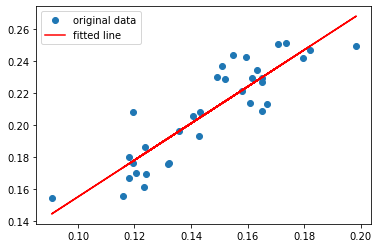

In [6]:
import matplotlib.pyplot as plt
plt.plot(noisy_exp_vals, noiseless_exp_vals, 'o', label='original data')
noisy_exp_vals = np.array(noisy_exp_vals)
plt.plot(noisy_exp_vals, slope*noisy_exp_vals + intercept, 'r', label='fitted line')

plt.legend()
plt.show()

In [7]:
'''
Prediction: run the original circuit and measure (= X_exact). 
Then, apply the function X_exact = slope*X_noisy + intercept to obtain the mitigated value. 
'''


# Running classical simulation
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram


# Testing: classical exact expectation value from the original circuit
psi_test = CircuitStateFn(qc)
exact_exp_val_test = (~psi_test @ observable @ psi_test).eval().real
print('Exact expectation value: ', exact_exp_val_test)


'''
For execution on qasm simulator: 
simulator = Aer.get_backend('qasm_simulator')
exact_result = execute(qc, simulator, shots=nshots).result()
exact_counts = exact_result.get_counts(qc)
exact_exp_val = expectation_value_from_counts(exact_counts)
print('Exact expectation value from counts: ', exact_exp_val)
'''

# Testing: quantum noisy expectation value on the original circuit

from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
from qiskit import transpile
from qiskit.providers.aer import AerSimulator
device_backend = FakeVigo()
coupling_map = device_backend.configuration().coupling_map
sim_vigo = AerSimulator.from_backend(device_backend)
tqc = transpile(circ_qc, sim_vigo) 

'''
For execution on quantum backends: 
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_lima')

tqc = transpile(qc_, qcomp) 
unmitigated_result = execute(qc, backend=qcomp, shots=nshots).result()
unmitigated_counts = unmitigated_result.get_counts(0) 
unmitigated_exp_val = expectation_value_from_counts(unmitigated_counts) 
print('Unmitigated expectation value from counts: ', unmitigated_exp_val)

'''

unmitigated_result = execute(circ_qc, backend=device_backend, shots=nshots).result() 
unmitigated_counts = unmitigated_result.get_counts(0) 
unmitigated_exp_val = expectation_value_from_counts(unmitigated_counts) 


# Mitigation
mitigated_exp_val = slope*unmitigated_exp_val + intercept
print('Mitigated expectation value from counts:', mitigated_exp_val)

# Error calculation
error_unmitigated = abs(unmitigated_exp_val-exact_exp_val_test)
error_mitigated = abs(mitigated_exp_val-exact_exp_val_test)
print("Error (unmitigated):", error_unmitigated)
print("Error (mitigated with CDR):", error_mitigated)

print("Relative error (unmitigated):", (error_unmitigated/exact_exp_val_test))
print("Relative error (mitigated with CDR):", error_mitigated/exact_exp_val_test)

print(f"Error reduction with CDR: {(error_unmitigated-error_mitigated)/error_unmitigated :.1%}.")

Exact expectation value:  0.20422260124463615
Mitigated expectation value from counts: 0.20140528209069625
Error (unmitigated): 0.06392260124463614
Error (mitigated with CDR): 0.002817319153939901
Relative error (unmitigated): 0.31300453943422213
Relative error (mitigated with CDR): 0.013795334780625302
Error reduction with CDR: 95.6%.
